# Module 4: Creating Text Classifiers 
June 2022, MSADS 509 - Applied Text Mining

**Context:** <div style="color:DarkCyan">This notebook will go through the process of creating a supervised learning model using the Java development tool bug dataset. this data can be accessed at the following <a href="https://github.com/logpai/bugrepo/tree/master/JDT">link.</a></div>

In [1]:
import pandas as pd
import requests
import io
jdt_url = "https://raw.githubusercontent.com/logpai/bugrepo/master/JDT/eclipse_jdt.csv"

In [147]:
#download our dataset from github
download = requests.get(jdt_url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1518,P1,Debug,NaN,Icons needed for actions (1GI5UXW),JGS (8/8/01 5:20:19 PM); \tWe need enabled; disabled & hover icons for the following actions:; \t\tCopyToClipboardActionDelegate; \t\tRelaunchActionDelegate; \t\tTerminateAndRemoveActionDelegate; ; DW (9/24/2001 2:22:48 PM); \tUse the standard copy icon for copy to clipboard (desktop likely exposes it).; ; DW (9/24/2001 2:23:05 PM); \tMade requests for; \t\tRelaunch; \t\tTerminate All; \t\tTerminate & Remove,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2001-10-18 11:51:14 -0400
1,1519,P3,Debug,NaN,README: Hit count not reset (1GET20Y),JGS (6/4/01 11:43:47 AM); \tSet a breakpoint in InfiniteLoop with a hit count. When suspended;; \tright click breakpoint in Breakpoints viewer and enable. Hit count; \tstays at previous value. Should it be reset to zero?; ; DW (6/4/01 11:50:23 AM); \tThis should just re-enable the breakpoint with the previous hit-count.; ; DS (6/4/2001 11:50:31 AM); \tTo change a hit count breakpoint into a normal breakpoint; you set its hit count to zero.; \tThis should likely be a readme item.; ; DW (6/4/01 6:33:43 PM); \tMake into a README.; ; DW (6/15/01 9:45:55 AM); \tAdded to README.,RESOLVED,WORKSFORME,2.0,2001-10-10 22:14:00 -0400,2001-11-28 13:42:46 -0500
2,1520,P3,Debug,NaN,Use styled text in console (1G9S1YF),DW (2/26/01 5:56:36 PM); \tCould allow users to use styled text in console; with preference support. This would; \tallow console input to be shown in bold; etc.,CLOSED,WONTFIX,2.0,2001-10-10 22:14:00 -0400,2002-06-26 11:32:05 -0400
3,1521,P3,Debug,NaN,StringBuffer representation (1GE3BFA),JGS (5/21/01 2:09:10 PM); \tTo be consistent; should we represent StringBuffer objects in the variables view like; \twe do Strings; with their values shown on the top node; so the user doesnt have to; \texpand the object and look at the char array?; ; DW (5/21/01 6:33:02 PM); \tDeferred - requires an evaluation.,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-05 10:37:09 -0500
4,1522,P2,Debug,1663.0,Feature: use #toString to display variable values (1G1Y25J),DW (9/27/00 11:12:31 AM); \tCurrently; the type of an object is shown in the variables view for ; its value.; \tOnly Strings and primitive types show concrete values. We should display; \tthe toString() of each object as its value. ; ; DW (10/23/00 11:22:02 AM); \tComments from CM:; ; \tFirst I need to define thread <g> because there are 2 of them:; 1) when I say thread; I mean a Java Thread; i.e. an object of type ; java.lang.Thread; 2) when I say vm thread; I mean the debuggers represenation of a thread in ; the VM;; \ti.e. an object of type com.oti.defrogger.model.DbgThread; ; So; when asked for an objects toString; the debugger creates a new thread; to do the following:; ; - lock the vm thread so that no other thread can invoke toString on that vm ; thread; ; - set a flag on the vm thread: fIsInvokingToString = true; ; - use INVOKE_SINGLE_THREADED to send toString() to the object in the vm thread; ; - set fIsInvokingToString = false; ; - unlock the vm thread; ; ; The fIsInvokin...,RESOLVED,DUPLICATE,2.0,2001-10-10 22:14:00 -0400,2001-10-17 10:17:47 -0400


In [3]:
#get a little more low-level.
pd.options.display.max_colwidth=1000
df.sample(1).T

,33322
Issue_id,158480
Priority,P3
Component,UI
Duplicated_issue,NaN
Title,Open Type not appearing in Navigate menu
Description,When editing Java source files; I dont get Open Type appearing anywhere. It does show Open Type Hierarchy.; ; The shortcut key ctrl-shift-T doesnt do anything.; ; Im new to Eclipse (1 week); so perhaps Im misunderstanding something.
Status,RESOLVED
Resolution,WORKSFORME
Version,3.1.2
Created_time,2006-09-24 17:41:00 -0400


We would also be interested in seeing the distribution of priority for tasks - to what extend is each priority level present in our data?
**P3 dominates the dataset as most individuals assume their bugs are not so crucial they block the application, but also do not want to classify them as low-priority and end up getting ignored.**

<AxesSubplot:title={'center':'Distribution of priority levels'}>

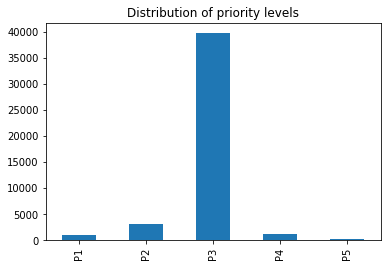

In [4]:
df['Priority'].value_counts().sort_index().plot(kind='bar',title="Distribution of priority levels")

We can also observe that UI, Core, Debug, and Text (in that order) take up the overwhelming majority of bugs. This dataset is pretty heavily imbalanced from both the priority and component points of view.

<AxesSubplot:title={'center':'Distribution of Component Bugs'}>

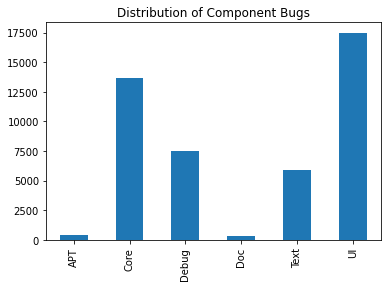

In [5]:
df['Component'].value_counts().sort_index().plot(kind='bar',title="Distribution of Component Bugs")

## Building A Text Classification System

### Step 1. Drop a bunch of Data

In [6]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title']+' '+df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

### Step 2: Clean Data

In [7]:
import html
import re
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [8]:
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2)

,Priority,text
38863,P3,StackOverflowError when saving Java file Build ID: M20080911-1700; ; Steps To Reproduce:; I have a Java class with a constructor calling another constructor via this(parameters...). The called constructor now has an additional argument. When I add that same argument to the end of the parameter list of this constructor and hit ctrl-s; the following Exception occurs (reproducibly; for the current state of the workbench).; ; More information:; java.lang.StackOverflowError; at org.eclipse.jdt.internal.compiler.lookup.Binding.isValidBinding(Binding.java:91); at org.eclipse.jdt.core.dom.DefaultBindingResolver.getMethodBinding(DefaultBindingResolver.java:230); at org.eclipse.jdt.core.dom.MethodBinding.getMethodDeclaration(MethodBinding.java:423); at org.eclipse.jdt.core.dom.DefaultBindingResolver.findDeclaringNode(DefaultBindingResolver.java:170); at org.eclipse.jdt.core.dom.CompilationUnit.findDeclaringNode(CompilationUnit.java:327); at org.eclipse.jdt.internal.corext.dom.ASTNodes.findDe...
13071,P3,no show in package explorer on text files 20030502; i actually have to remember where the file is and hunt for it every time


### Step 2: Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
#80-20 train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'],
    df['Priority'],
    test_size=0.2,
    random_state=42,
    stratify=df['Priority']
)

Next, we create a TF-IDF Vectorizer.

In [13]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [14]:
#sanity check - we're not really gonna get much insight here.
X_train_tf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Approach 1: The linear SVC

In [15]:
#the linearSVC implementation of a support vector machine is generally the fastest
from sklearn.svm import LinearSVC
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [16]:
from sklearn.metrics import accuracy_score
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


#### Comparrison - A Baseline Guessing Model

In [17]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8769281988680502


**Our main takeaway is that a linear SVM did almost nothing to make the performance better than just guessing the most frequent priority.**

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


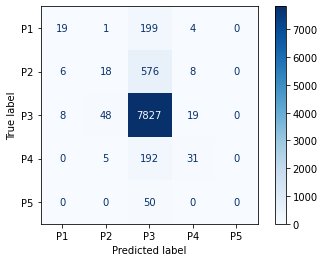

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
plot_confusion_matrix(model1,X_test_tf,
    Y_test, values_format='d',
    cmap=plt.cm.Blues)
plt.show()

it appears our model is really good at predicting P3, and pretty much nothing else.

In [20]:
from sklearn.metrics import classification_report 
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

More of the same - p3 is the only class that's getting good results in any direction.

### Understanding Why LinearSVM Failed
<p style="color:cadetblue"><b>The biggest reason our model was great at P3 and nothing else was because of a heavy class imbalance. We can fix this problem by undersampling the P3 class.</b></p>

In [21]:
df['Priority'].value_counts() #it's clear that we have way too many P3 samples, so we can reduce them down to 4000

P3    39506
P2     3038
P4     1138
P1     1117
P5      252
Name: Priority, dtype: int64

In [22]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000)
# Create a separate DataFrame containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']
df_resamples = pd.concat([df_sampleP3,df_sampleRest],axis=0)
df_resamples.head()

,Priority,text
37727,P3,Open Type does not work with nested build path. I have my source tree like this.; Root-|; |-A1-|; |-A1.java; |-A2; |-File.java; ; In my build path I have added Root with inclusion pattern File.java.; Also I have A1 and A2 in build path.; ; It works till I refresh. After refreshing; Open Type does not find anything under A1 such as A1.java.; It shows File could not be found in Root. Make sure all workspace resources are refreshed. Screenshot attached.; ; Ive also tried with excluding A1;A2 from Root; still same result.
24839,P3,Code assist inserts unneeded type parameters 1) In the following code execute code assist at |:; public static void main(String args) {; Vector| v= new Vector ();; }; ; 2) select java.util.Vector (with the intent to add ; the import statement). You get the following completion:; public static void main(String args) {; Vector v= new Vector ();; }; ; This is highly annoying since now you can no longer add; an import statement by just using code assist.
36027,P3,Generates incorrect Parameter Use Extract Class on junit.runner.TestCaseClassLoader and generate alle Getters and Setters for all fields.; The initialization of field private String defaultExclusions= {; junit.framework.; ; junit.extensions.; ; junit.runner.; };; will fail because the array creation needs to be inserted
43532,P3,NPE on open Call Hierarchy Unfortunately Ive no save repro for the exception below. What I tried to fix this is a clean build and deleting the contents from the metadata of my workspace. Both without success. I dont see any error markers in my workspace.; ; Version info (why tis the build-id different from the v-date in the version?); Eclipse Java Development Tools; ; Version: 3.8.0.v20111130-1318-8-8lFpEFNOfwRe0lvGVLmVw9B15B; Build id: I20120314-1800; ; Message from the newsgroup:; ; Recently I got the following exception when I tried to use the call hierarchy. I dont get an error dialog but a message in the error log instead. No callers are found though there are some. Is there something that I can do on my machine to fix that / the index / the project config / whatever may have caused that?; ; Thanks in advance;; Sebastian; ; java.lang.NullPointerException; at org.eclipse.jdt.internal.core.search.matching.ClasspathSourceDirectory.directoryTable(ClasspathSourceDirectory.java:44);...
17954,P3,DebugException: Invalid stack frame I20040310 code (incl. Debug) from HEAD; ; I am used to have log entries while debugging but today it got fille with:; ; !ENTRY org.eclipse.jdt.launching 4 4 Mrz 15; 2004 13:04:19.474; !MESSAGE Invalid stack frame; !STACK 1; org.eclipse.debug.core.DebugException: Invalid stack frame; at; org.eclipse.jdt.internal.debug.core.model.JDIStackFrame.getUnderlyingStackFrame(JDIStackFrame.java:956); at; org.eclipse.jdt.internal.debug.core.model.JDIStackFrame.getSourceName(JDIStackFrame.java:839); at; org.eclipse.jdt.launching.sourcelookup.JavaSourceLocator.getFullyQualfiedName(JavaSourceLocator.java:274); at; org.eclipse.jdt.launching.sourcelookup.JavaSourceLocator.getSourceElements(JavaSourceLocator.java:205); at; org.eclipse.jdt.debug.ui.JavaUISourceLocator.findSourceElement(JavaUISourceLocator.java:164); at; org.eclipse.jdt.debug.ui.JavaUISourceLocator.getSourceElement(JavaUISourceLocator.java:145); at; org.eclipse.jdt.internal.debug.ui.JavaWatchExpress...


### Take Two: SVM With Balanced DF

In [23]:
#clean up kernel space
df = df_resamples[['text', 'Priority']]
df = df.dropna()

In [24]:
#clean everything up
df['text'] = df['text'].apply(clean)

In [25]:
#80-20 train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text'],
    df['Priority'],
    test_size=0.2,
    random_state=42,
    stratify=df['Priority']
)

In [26]:
#Vectorize
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [27]:
#Try again
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [28]:
from sklearn.metrics import accuracy_score
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.5028810895756941


In [29]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.45      0.29      0.35       223
          P2       0.44      0.44      0.44       608
          P3       0.56      0.69      0.62       800
          P4       0.45      0.33      0.38       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



## Our new accuracy is even lower than previously generated, and is only slightly better than guessing randomly. P3 continues to have the best f1 score.

The primary reason for this is that our TF-IDF vectorized isn't effective on face value at generating a high-performing model. Removing stop words, creating lemmas, parts of speech, and more is needed to make this effective.

In [39]:
import spacy
import textacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
 compile_infix_regex, compile_suffix_regex

In [31]:
def custom_tokenizer(nlp):
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes
    if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
    if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes
    if not re.search(pattern, 'xx-xx')]
    return Tokenizer(vocab = nlp.vocab,
    rules = nlp.Defaults.tokenizer_exceptions,
    prefix_search = compile_prefix_regex(prefixes).search,
    suffix_search = compile_suffix_regex(suffixes).search,
    infix_finditer = compile_infix_regex(infixes).finditer,
    token_match = nlp.Defaults.token_match)

def extract_nlp(doc):
     return {
         'lemmas' : extract_lemmas(doc,
         exclude_pos = ['PART', 'PUNCT',
         'DET', 'PRON', 'SYM', 'SPACE'],
         filter_stops = False),
         'adjs_verbs' : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
         'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
         'noun_phrases' : extract_noun_phrases(doc, ['NOUN']),
         'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
         'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
     }
    
def extract_lemmas(doc, **kwargs):
     return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]
    
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
        
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns) 
    return [sep.join([t.lemma_ for t in s]) for s in spans]

def extract_entities(doc, include_types=None, sep='_'):
    
    ents = textacy.extract.entities(
        doc,
        include_types=include_types,
        exclude_types=None,
        drop_determiners=True,
        min_freq=1
    )
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]


In [84]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional
sw = nlp.Defaults.stop_words

In [85]:
#create columns for lemmatization, POS tagging, NER, etc.
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
for col in nlp_columns:
    df[nlp_columns] = None

In [108]:
#make everything lowercase
df['text'] = df['text'].map(str.lower)

In [109]:
#process into columns (standard)
batch_size = 50
for i in range(0, len(df), batch_size):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

In [88]:
#additional create a lemmatization that has no stop words
def remove_stop_words(lemmas):
    return [lemma for lemma in lemmas if lemma.lower() not in sw]

In [89]:
#accepts a dataframe series of tokenized texts and returns an array.
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import pandas as pd 
from wordcloud import WordCloud 

def combine_tokens(tokens):
    out = []
    for token_list in tokens:
        out = out + token_list
    return out

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#accepts a pandas series object of tokens and returns a dictionary
def get_frequency(tokensObj,count_name = 'count'):
    #convert into a list.
    import pandas as pd 
    tokens_count = Counter(combine_tokens(tokensObj))
    count_df = pd.DataFrame.from_dict(tokens_count, orient='index').reset_index()
    return(count_df.rename(columns={'index':'token',0:count_name}))

In [122]:
#remove any lemmas that are fully numerical
all_numerical_pattern = re.compile(r"[a-zA-Z]")
df['lemmas'] = df['lemmas'].apply(lambda x: [i for i in x if re.search(all_numerical_pattern,i) is not None])

In [123]:
df['lemmas_no_sw'] = df['lemmas'].map(remove_stop_words)
df.head(1)

,text,Priority,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,lemmas_no_sw
37727,open type does not work with nested build path. i have my source tree like this.; root-|; |-a1-|; |-a1.java; |-a2; |-file.java; ; in my build path i have added root with inclusion pattern file.java.; also i have a1 and a2 in build path.; ; it works till i refresh. after refreshing; open type does not find anything under a1 such as a1.java.; it shows file could not be found in root. make sure all workspace resources are refreshed. screenshot attached.; ; ive also tried with excluding a1;a2 from root; still same result.,P3,"[open, type, do, work, with, nest, build, path, have, source, tree, like, root-|, in, build, path, have, add, root, with, inclusion, pattern, file.java, also, have, a1, and, a2, in, build, path, work, till, refresh, after, refresh, open, type, do, find, under, a1, such, as, a1.java, show, file, could, be, find, in, root, make, sure, workspace, resource, be, refresh, screenshot, attach, ve, also, try, with, exclude, a1;a2, from, root, still, same, result]","[open, work, nest, add, work, refresh, refresh, open, find, show, find, sure, workspace, refresh, attach, try, exclude]","[type, build, path, source, tree, |-a1-|, |-a1.java, |-a2, |-file.java, build, path, root, inclusion, pattern, a1, a2, build, path, type, a1, a1.java, file, root, resource, screenshot, root, result]","[build_path, source_tree, build_path, inclusion_pattern, build_path]","[open_type, open_type, same_result]","[root-|_;/GPE, |-a2/GPE]","[open, type, work, nest, build, path, source, tree, like, root-|, build, path, add, root, inclusion, pattern, file.java, a1, a2, build, path, work, till, refresh, refresh, open, type, find, a1, a1.java, file, find, root, sure, workspace, resource, refresh, screenshot, attach, ve, try, exclude, a1;a2, root, result]"


In [93]:
classes = df['Priority'].unique()
classes.sort()

In [101]:
for p in classes:
    this_df = df[df['Priority']==p]
    print(f'lemma count for {p} - count: {len(this_df)}')
    this_freq = get_frequency(this_df['adj_noun_phrases']).sort_values(by='count',ascending=False)
    print(this_freq[0:10])

lemma count for P1 - count: 1117
                     token  count
87            public_class    118
587   unchanged_class_file     56
586        unchanged_class     56
35          internal_error     52
585   affected_source_file     44
584        affected_source     44
2024      different_output     28
658          new_workspace     18
297            main_method     17
14             public_void     17
lemma count for P2 - count: 3038
               token  count
10      public_class    347
754    add_dependent    175
1818       quick_fix     52
54    internal_error     52
311      inner_class     51
712      stack_trace     45
395   local_variable     42
11       public_void     42
505        open_type     41
527        new_class     35
lemma count for P3 - count: 4000
                token  count
16       public_class    692
41          quick_fix    166
28   More_information    163
29        public_void    125
24        inner_class     97
69     public_class_x     89
179    local_var

In [134]:
lemmas = df['nouns'].apply(lambda x: " ".join(x))
print(lemmas[0])

icon action jgs pm icon action relaunchactiondelegate terminateandremoveactiondelegate 9/24/2001 pm copy icon copy clipboard desktop pm request remove


In [135]:
#80-20 train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    lemmas,
    df['Priority'],
    test_size=0.2,
    random_state=42,
    stratify=df['Priority']
)

#Vectorize
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

#Try again
model2 = LinearSVC(random_state=0, tol=1e-5)
model2.fit(X_train_tf, Y_train)

X_test_tf = tfidf.transform(X_test)
Y_pred = model2.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.5165007857517024
              precision    recall  f1-score   support

          P1       0.45      0.29      0.35       223
          P2       0.45      0.46      0.45       608
          P3       0.57      0.72      0.64       800
          P4       0.50      0.29      0.37       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.52      1909
   macro avg       0.39      0.35      0.36      1909
weighted avg       0.50      0.52      0.50      1909



## Cross Validation

In [138]:
# Vectorization
from sklearn.model_selection import cross_val_score
lemmas = df['lemmas_no_sw'].apply(lambda x: " ".join(x))
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(lemmas).toarray()
# Cross Validation with 5 folds
scores = cross_val_score(estimator=model1,
    X=df_tf,
    y=df['Priority'],
    cv=5
)
print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.45102148 0.45940283 0.43897328 0.37977999 0.37297014]
Mean value across of validation scores  0.42042954426401263
Standard deviation of validation scores  0.0366153923344854


## Grid Search

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.

training_pipeline = Pipeline(
 steps=[('tfidf', TfidfVectorizer(stop_words="english")),
 ('model', LinearSVC(random_state=42, tol=1e-5))])
grid_param = [{
 'tfidf__min_df': [5, 10],
 'tfidf__ngram_range': [(1, 3), (1, 6)],
 'model__penalty': ['l2'],
 'model__loss': ['hinge'],
 'model__max_iter': [10000]
}, {
 'tfidf__min_df': [5, 10],
 'tfidf__ngram_range': [(1, 3), (1, 6)],
 'model__C': [1, 10],
 'model__tol': [1e-2, 1e-3]
}]
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
 param_grid=grid_param,
cv=5)
gridSearchProcessor.fit(lemmas, df['Priority'])
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.43761131482451543


## Grid Search 2:
#### Instead of trying to guess the priority, let's guess the component!

In [153]:
#download our dataset from github
download = requests.get(jdt_url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1518,P1,Debug,NaN,Icons needed for actions (1GI5UXW),JGS (8/8/01 5:20:19 PM); \tWe need enabled; disabled & hover icons for the following actions:; \t\tCopyToClipboardActionDelegate; \t\tRelaunchActionDelegate; \t\tTerminateAndRemoveActionDelegate; ; DW (9/24/2001 2:22:48 PM); \tUse the standard copy icon for copy to clipboard (desktop likely exposes it).; ; DW (9/24/2001 2:23:05 PM); \tMade requests for; \t\tRelaunch; \t\tTerminate All; \t\tTerminate & Remove,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2001-10-18 11:51:14 -0400
1,1519,P3,Debug,NaN,README: Hit count not reset (1GET20Y),JGS (6/4/01 11:43:47 AM); \tSet a breakpoint in InfiniteLoop with a hit count. When suspended;; \tright click breakpoint in Breakpoints viewer and enable. Hit count; \tstays at previous value. Should it be reset to zero?; ; DW (6/4/01 11:50:23 AM); \tThis should just re-enable the breakpoint with the previous hit-count.; ; DS (6/4/2001 11:50:31 AM); \tTo change a hit count breakpoint into a normal breakpoint; you set its hit count to zero.; \tThis should likely be a readme item.; ; DW (6/4/01 6:33:43 PM); \tMake into a README.; ; DW (6/15/01 9:45:55 AM); \tAdded to README.,RESOLVED,WORKSFORME,2.0,2001-10-10 22:14:00 -0400,2001-11-28 13:42:46 -0500
2,1520,P3,Debug,NaN,Use styled text in console (1G9S1YF),DW (2/26/01 5:56:36 PM); \tCould allow users to use styled text in console; with preference support. This would; \tallow console input to be shown in bold; etc.,CLOSED,WONTFIX,2.0,2001-10-10 22:14:00 -0400,2002-06-26 11:32:05 -0400
3,1521,P3,Debug,NaN,StringBuffer representation (1GE3BFA),JGS (5/21/01 2:09:10 PM); \tTo be consistent; should we represent StringBuffer objects in the variables view like; \twe do Strings; with their values shown on the top node; so the user doesnt have to; \texpand the object and look at the char array?; ; DW (5/21/01 6:33:02 PM); \tDeferred - requires an evaluation.,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2002-02-05 10:37:09 -0500
4,1522,P2,Debug,1663.0,Feature: use #toString to display variable values (1G1Y25J),DW (9/27/00 11:12:31 AM); \tCurrently; the type of an object is shown in the variables view for ; its value.; \tOnly Strings and primitive types show concrete values. We should display; \tthe toString() of each object as its value. ; ; DW (10/23/00 11:22:02 AM); \tComments from CM:; ; \tFirst I need to define thread <g> because there are 2 of them:; 1) when I say thread; I mean a Java Thread; i.e. an object of type ; java.lang.Thread; 2) when I say vm thread; I mean the debuggers represenation of a thread in ; the VM;; \ti.e. an object of type com.oti.defrogger.model.DbgThread; ; So; when asked for an objects toString; the debugger creates a new thread; to do the following:; ; - lock the vm thread so that no other thread can invoke toString on that vm ; thread; ; - set a flag on the vm thread: fIsInvokingToString = true; ; - use INVOKE_SINGLE_THREADED to send toString() to the object in the vm thread; ; - set fIsInvokingToString = false; ; - unlock the vm thread; ; ; The fIsInvokin...,RESOLVED,DUPLICATE,2.0,2001-10-10 22:14:00 -0400,2001-10-17 10:17:47 -0400


In [158]:
from sklearn.svm import SVC 

In [156]:
df['text'] = df['Title'] +' '+df['Description']
df['text'] = df['text'].astype(str)

In [159]:
# Flag that determines the choice of SVC and LinearSVC
runSVC = True

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
    random_state=21,
    frac=.2)
    
# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
 df['Component'],
 test_size=0.2,
random_state=42,
stratify=df['Component'])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")
if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 100],
    'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
     }
    
training_pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,param_grid=grid_param,cv=5)
    
gridSearchProcessor.fit(X_train, Y_train)
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)
best_model = gridSearchProcessor.best_estimator_
# Step 4 - Model Evaluation
Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))


Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.6662101114955787
Accuracy Score -  0.7257617728531855
              precision    recall  f1-score   support

         APT       0.00      0.00      0.00         3
        Core       0.76      0.76      0.76       109
       Debug       0.96      0.73      0.83        60
         Doc       0.00      0.00      0.00         3
        Text       0.61      0.40      0.49        47
          UI       0.66      0.83      0.74       139

    accuracy                           0.73       361
   macro avg       0.50      0.46      0.47       361
weighted avg       0.72      0.73      0.72       361



c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [162]:
#we will hold on to this because we will be using this to retrain our model.
best_params

{'model__C': 1,
 'model__kernel': 'linear',
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 3)}

## Chapter 7: Explaining Text Classifiers

We begin by re-running our SVM and printing out a series of data points that were not classified correctly, picking one out,and determining if we can separate the patterns behind "good" and "bad" predictions.

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

svc = SVC(kernel="linear", C=1, probability=True, random_state=42)
svc.fit(X_train_tf, Y_train)

X_test_tf = tfidf.transform(X_test)
Y_pred = svc.predict(X_test_tf)
result = pd.DataFrame({ 'text': X_test.values, 'actual': Y_test.values,
 'predicted': Y_pred })


In [179]:
result[result["actual"] != result["predicted"]].sample(n=5)

,text,actual,predicted
52,Doc Javadocs of 2.0 classes must specify if the class is intended to be instantiated or subclassed by client.,Core,UI
292,IOOBoundsException from FindReplaceDialog.writeHistory 20060410-0010; ; found the following exception in my log; ; java.lang.IndexOutOfBoundsException: Index: 8; Size: 8; at java.util.ArrayList.RangeCheck(ArrayList.java:546); at java.util.ArrayList.remove(ArrayList.java:389); at org.eclipse.ui.texteditor.FindReplaceDialog.writeHistory(FindReplaceDialog.java:1739); at org.eclipse.ui.texteditor.FindReplaceDialog.writeConfiguration(FindReplaceDialog.java:1708); at org.eclipse.ui.texteditor.FindReplaceDialog.storeSettings(FindReplaceDialog.java:1006); at org.eclipse.ui.texteditor.FindReplaceDialog.handleDialogClose(FindReplaceDialog.java:967); at org.eclipse.ui.texteditor.FindReplaceDialog.close(FindReplaceDialog.java:945); at org.eclipse.ui.texteditor.FindReplaceDialog.buttonPressed(FindReplaceDialog.java:742); at org.eclipse.jface.dialogs.Dialog$3.widgetSelected(Dialog.java:652); at org.eclipse.swt.widgets.TypedListener.handleEvent(TypedListener.java:90); at org.eclipse.swt.widgets.E...,Text,UI
206,Display var/expression shows in unreadable popup When a Display is done on a variable/expression; the popup it shows up in is; so small; one cant see what the value is (this may be related to bug 58476); ; Also; it reports to hit ctrl-shift-d to place it in display view; but; ctrl-shift-v is what works (ctrl-shift-d just shows a funky underline D char; near the popup); ; This is on eclipse build 200405060200 on linux fedora core 1,Debug,UI
234,Improve default format template Cay Horstmann has pointed out that current default format template is far from optimal. It would probably be more useful to include super.toString() instead of class name. This way the Object implementation of toString() inserts a full class name (also with a useless hash; but thats not a big problem) and each subclass can add their fields at the end. Heres a proposition for the template:; ; ${object.superToString} ; ; Would that modification be suitable for 3.5.1?; ; http://weblogs.java.net/blog/cayhorstmann/archive/2009/06/upgrading_to_ec.html,UI,Core
175,Exception renaming project containing shared config I20050909-2010; ; If I rename a project containing a shared launch configuration; I get an ; exception like this:; ; org.eclipse.core.runtime.CoreException: Unable to generate memento for ; VectorTesting; shared file does not exist.; at org.eclipse.debug.internal.core.LaunchConfiguration.getMemento; (LaunchConfiguration.java:389); at ; org.eclipse.debug.internal.ui.launchConfigurations.LaunchConfigurationManager.c; reateEntry(LaunchConfigurationManager.java:337); at ; org.eclipse.debug.internal.ui.launchConfigurations.LaunchConfigurationManager.g; etHistoryAsXML(LaunchConfigurationManager.java:318); at ; org.eclipse.debug.internal.ui.launchConfigurations.LaunchConfigurationManager.p; ersistLaunchHistory(LaunchConfigurationManager.java:358); at org.eclipse.debug.internal.ui.launchConfigurations.LaunchHistory.save; (LaunchHistory.java:121); at ; org.eclipse.debug.internal.ui.launchConfigurations.LaunchHistory.launchConfigur; ationRe...,Debug,UI


**In our case, ID = 234 is a great candidate because the wording clearly suggests that this might be a UI task. Let's inspect it further:**

In [182]:
text = result.iloc[234]
print(text)

text         Improve default format template Cay Horstmann has pointed out that current default format template is far from optimal. It would probably be more useful to include super.toString() instead of class name. This way the Object implementation of toString() inserts a full class name (also with a useless hash; but thats not a big problem) and each subclass can add their fields at the end. Heres a proposition for the template:; ; ${object.superToString} ; ; Would that modification be suitable for 3.5.1?; ; http://weblogs.java.net/blog/cayhorstmann/archive/2009/06/upgrading_to_ec.html
actual                                                                                                                                                                                                                                                                                                                                                                                                             

Let's examine the probability of each class for this task - we know that Core has a probability of 54%, with the 2nd best result being a 31% confidence. Let's determine if there's a meaningful prediction difference in rows where the margin between the predicted and 2nd most confident result is large.

In [191]:
svc.predict_proba(X_test_tf[234])

array([[0.00503853, 0.30948092, 0.02885275, 0.00421294, 0.54338805,
        0.10902681]])

In [193]:
class_names = ["APT", "Core", "Debug", "Doc", "Text", "UI"]
prob = svc.predict_proba(X_test_tf)

### Begin by generating a matrix of prediction confidences for each test case.

In [223]:
# new dataframe for explainable results
er = result.copy().reset_index()
for c in enumerate(class_names):
    er[c[1]] = prob[:,c[0]]
    
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

,actual,predicted,APT,Core,Debug,Doc,Text,UI
243,Debug,UI,0.002177,0.134378,0.163085,0.006804,0.068369,0.625188
170,Core,Core,0.001618,0.654064,0.030833,0.004808,0.165219,0.143457
171,UI,UI,0.003756,0.117092,0.021379,0.021544,0.241444,0.594785
251,UI,UI,0.004364,0.257883,0.006563,0.002578,0.018202,0.710411
7,UI,UI,0.001259,0.257537,0.014773,0.004501,0.195447,0.526484


In this table, only the first row has an incorrect prediction, and the UI field is far and away the most confident.

#### Continue by seeing, for both correct and wrong predictions, how the distribution of confidence affects model accuracy:

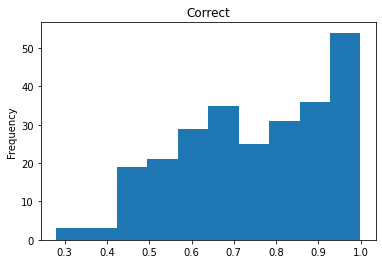

<AxesSubplot:title={'center':'Wrong'}, ylabel='Frequency'>

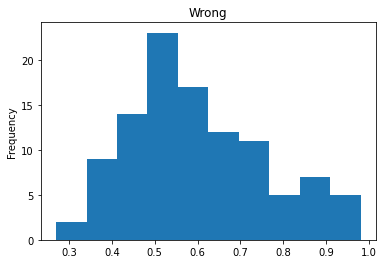

In [225]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong = (er[er['actual'] != er['predicted']])
#We will now plot this as a histogram:
correct["max_probability"].plot.hist(title="Correct")
plt.show()
wrong["max_probability"].plot.hist(title="Wrong")

As a result, we can conclude that the majority of "bad" predictions occur when the confidence is below 80%. Let's entertain a model where any rows with a max probability below 80% are ignored:

In [226]:
high = er[er["max_probability"] > 0.8]
print(classification_report(high["actual"], high["predicted"]))

              precision    recall  f1-score   support

        Core       0.91      0.94      0.93        34
       Debug       0.95      0.90      0.93        42
        Text       0.73      0.85      0.79        13
          UI       0.87      0.85      0.86        40

    accuracy                           0.89       129
   macro avg       0.87      0.89      0.88       129
weighted avg       0.89      0.89      0.89       129



In [228]:
#Compare it with the older report:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

         APT       0.00      0.00      0.00         3
        Core       0.73      0.73      0.73       109
       Debug       0.90      0.75      0.82        60
         Doc       0.00      0.00      0.00         3
        Text       0.59      0.43      0.49        47
          UI       0.66      0.80      0.72       139

    accuracy                           0.71       361
   macro avg       0.48      0.45      0.46       361
weighted avg       0.70      0.71      0.70       361



c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

### While we improved performance, we also got rid of the APT and Debug classes. Our recall improves greatly for some categories, but we also removed over half the test set.

## Measuring Feature Importance

In [229]:
svc.coef_

<15x13261 sparse matrix of type '<class 'numpy.float64'>'
	with 67709 stored elements in Compressed Sparse Row format>

#### Why the 15 in 15 x 13261?
Each class competes for uniqueness against every other class in a one-to-one way, and each term helps determine the coefficient of separation betwen classes. There's 6 classes, so we would have 6x6 = 36 point matrix. Remove the symmetry and the fact that classes don't compete with themselves and we get:
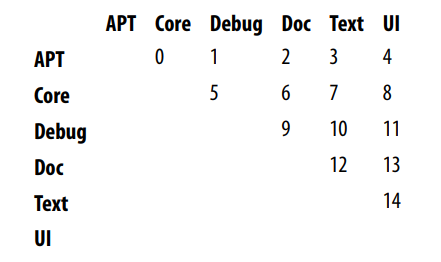

The rows should be read first, so if we want to find out how the model distinguishes
APT from Core, we should take index 0 of the coefficients. However, we are more
interested in the difference of Core and UI, so we take index **8**. In the first step, we
sort the coefficients by their values and keep the indices, which are the vocabulary
positions:

In [232]:
#for each word, get the significance of a variable for differences between core and UI.
coef = svc.coef_[8].A[0]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names()

<AxesSubplot:ylabel='feature'>

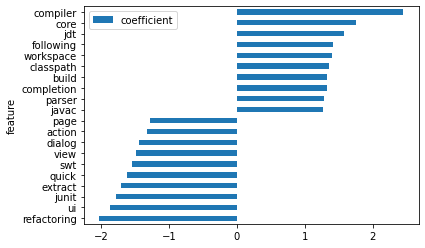

In [231]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

#make a dataframe and plot it 
core_ui = pd.DataFrame([[vocabulary[c],
 coef[c]] for c in top_positive_coef + top_negative_coef],
 columns=["feature", "coefficient"]).sort_values("coefficient")

core_ui.set_index("feature").plot.barh()

#### Interp: Compiler, Core, and JDT are uniquely related to Core while UI, refactoring, and junit are uniquely related to UI.

# LIME - Local Interpretable Model-Agnostic Explanations

LIME was conceived as a way to locally look at each prediction in our test set and come up with an interpretation. It takes a very long time for sample spaces that are large, and has the following traits:
<ul>
    <li>LIME can accept any ML model where the probability of each class is predicted.</li>
    <li>LIME takes a long time in high-feature spaces like those in text mining.</li>
    <li>LIME generates explanations on a per-sample basis.</li>
</ul>

In [255]:
from sklearn.pipeline import make_pipeline
tfidf = TfidfVectorizer(stop_words="english")
pipeline = make_pipeline(tfidf, best_model)
pipeline.predict(["compiler not working"])

AttributeError: lower not found